Python 程序在运行的时候，需要在内存中开辟出一块空间，用于存放运行时产生的临时变量；计算完成后，再将结果输出到永久性存储器中。如果数据量过大，内存空间管理不善就很容易出现 OOM（out of memory），俗称爆内存，程序可能被操作系统中止。

而对于服务器，这种设计为永不中断的系统来说，内存管理则显得更为重要，不然很容易引发内存泄漏。什么是内存泄漏呢？ 
1. 这里的泄漏，并不是说你的内存出现了信息安全问题，被恶意程序利用了，而是指程序本身没有设计好，导致程序未能释放已不再使用的内存。 
2. 内存泄漏也不是指你的内存在物理上消失了，而是意味着代码在分配了某段内存后，因为设计错误，失去了对这段内存的控制，从而造成了内存的浪费。


# Python 是通过什么机制来回收这些空间的呢

## 计数引用

由于Python中一切皆为对象，所以我们定义的变量，本质上都是对象的一个指针。

当对象被引用的时候，对象的引用计数不为。反之，如果一个对象的引用计数为0，则表示该对象不会被调用，即需要被回收。


In [1]:
import os
import psutil

# 显示当前 python 程序占用的内存大小
def show_memory_info(hint):
    pid = os.getpid()
    p = psutil.Process(pid)
    
    info = p.memory_full_info()
    memory = info.uss / 1024. / 1024
    print('{} memory used: {} MB'.format(hint, memory))


In [2]:
def func():
    show_memory_info('initial')
    a = [i for i in range(10000000)]
    show_memory_info('after a created')

func()
show_memory_info('finished')


initial memory used: 54.51953125 MB
after a created memory used: 439.125 MB
finished memory used: 56.80859375 MB


通过这个示例，你可以看到，调用函数 func()，在列表 a 被创建之后，内存占用迅速增加到了 443 MB：而在函数调用结束后，内存则返回正常。

这是因为，**函数内部声明的列表 a 是局部变量，在函数返回后，局部变量的引用会注销掉**；此时，列表 a 所指代对象的引用数为 0，Python 便会执行垃圾回收，因此之前占用的大量内存就又回来了。

In [3]:
def func():
    show_memory_info('initial')
    global a
    a = [i for i in range(10000000)]
    show_memory_info('after a created')
    
    
func()
show_memory_info('finished')


initial memory used: 56.85546875 MB
after a created memory used: 439.1875 MB
finished memory used: 439.1875 MB


新的这段代码中，**global a 表示将 a 声明为全局变量。那么，即使函数返回后，列表的引用依然存在，于是对象就不会被垃圾回收掉，依然占用大量内存**。

同样，如果我们**把生成的列表返回，然后在主程序中接收，那么引用依然存在，垃圾回收就不会被触发**，大量内存仍然被占用着：

In [2]:
def func():
    show_memory_info('initial')
    a = [i for i in range(10000000)]
    show_memory_info('after a created')
    return a

a = func()
show_memory_info('finished')

initial memory used: 54.3359375 MB
after a created memory used: 438.91796875 MB
finished memory used: 438.91796875 MB


## Python 内部的引用计数机制

`sys.getrefcount()`这个函数，可以查看一个变量的引用次数。`getrefcount` 本身也会引入一次计数。

另一个要注意的是，在函数调用发生的时候，会产生额外的两次引用，一次来自函数栈，另一个是函数参数。

In [3]:
import sys


# 两次引用，一次来自 a，一次来自 getrefcount
a = []
print(sys.getrefcount(a))



# 四次引用，a，python 的函数调用栈，函数参数，和 getrefcount
def func(a):
    print(sys.getrefcount(a))

func(a)



# 两次引用，一次来自 a，一次来自 getrefcount，函数 func 调用已经不存在
print(sys.getrefcount(a))


2
3
2


下面的代码，需要稍微注意一下，a、b、c、d、e、f、g 这些变量全部指代的是同一个对象，而 `sys.getrefcount()` 函数并不是统计一个指针，而是要统计一个对象被引用的次数，所以最后一共会有八次引用。       

In [4]:
import sys

a = []

print(sys.getrefcount(a)) # 两次, a, getrefcount

b = a

print(sys.getrefcount(a)) # 三次, a, b, getrefcount

c = b
d = b
e = c
f = e
g = d

print(sys.getrefcount(a)) # 八次, a, b, c, d, e, f, g ,getrefcount



2
3
8


理解引用这个概念后，引用释放是一种非常自然和清晰的思想。相比 C 语言里，你需要使用 free 去手动释放内存，Python 的垃圾回收在这里可以说是省心省力了。 

不过，如果我偏偏想手动释放内存，应该怎么做呢？ 

方法同样很简单。你只需要先调用 `del a` 来删除对象的引用；然后强制调用 `gc.collect()`，清除没有引用的对象，即可手动启动垃圾回收。

In [5]:
import gc

show_memory_info('initial')

a = [i for i in range(10000000)]

show_memory_info('after a created')

del a
gc.collect()

show_memory_info('finish')
print(a)


initial memory used: 56.5546875 MB
after a created memory used: 439.85546875 MB
finish memory used: 57.5390625 MB


NameError: name 'a' is not defined

## 循环引用

如果有两个对象，它们互相引用，并且不再被别的对象所引用，那么它们应该被垃圾回收吗？

这里，a 和 b 互相引用，并且，作为局部变量，在函数 func 调用结束后，a 和 b 这两个指针从程序意义上已经不存在了。但是，很明显，依然有内存占用！为什么呢？因为互相引用，导致它们的引用数都不为 0。

In [6]:
def func():
    show_memory_info('initial')
    a = [i for i in range(10000000)]
    b = [i for i in range(10000000)]
    show_memory_info('after a, b created')
    a.append(b)
    b.append(a)

func()
show_memory_info('finished')


initial memory used: 61.2109375 MB
after a, b created memory used: 831.81640625 MB
finished memory used: 831.81640625 MB



试想一下，如果这段代码出现在生产环境中，哪怕 a 和 b 一开始占用的空间不是很大，但经过长时间运行后，Python 所占用的内存一定会变得越来越大，最终撑爆服务器，后果不堪设想。

当然，有人可能会说，互相引用还是很容易被发现的呀，问题不大。可是，更隐蔽的情况是出现一个引用环，在工程代码比较复杂的情况下，引用环还真不一定能被轻易发现。 那么，我们应该怎么做呢？

In [7]:
import gc

def func():
    show_memory_info('initial')
    a = [i for i in range(10000000)]
    b = [i for i in range(10000000)]
    show_memory_info('after a, b created')
    a.append(b)
    b.append(a)

func()
gc.collect()
show_memory_info('finished')


initial memory used: 831.82421875 MB
after a, b created memory used: 1599.56640625 MB
finished memory used: 67.26953125 MB


Python 使用标记清除（mark-sweep）算法和分代收集（generational），来启用针对循环引用的自动垃圾回收。需要理解：

1. 不可达节点： 对于一个有向图，如果从一个节点出发进行遍历，并标记其经过的所有节点。那么，在遍历结束后，所有没有被标记的节点，称之为不可达节点。  --由于这些节点没有任何的意义，所以在垃圾回收中需要被回收。
2. mark-sweep: 由于每次豆遍历全图的性能消耗太大，所以在垃圾回收机制中，使用双向链表维护一个数据结构，并且只考虑容器类的对象（只有容器内的对象才会产生循环引用）
3. 分代收集：Python将所有对象分为三代。刚创建的对象为第0代，经过一次回收后仍然存在的对象，便会依次从上一代挪到下一代。而每一代启动垃圾回收的阈值，则是可以单独指定的。当垃圾回收器中新增对象减去删除对象达到相应的阈值时，就会对这一代对象启动垃圾回收。

事实上，分代收集基于的思想是，新生的对象更有可能被垃圾回收，而存活更久的对象也有更高的概率继续存活。因此，通过这种做法，可以节约不少计算量，从而提高 Python 的性能。

引用计数是其中最简单的实现，不过切记，引用计数并非充要条件，它只能算作充分非必要条件；至于其他的可能性，我们所讲的循环引用正是其中一种。

## 调试内存泄漏

虽然有了自动回收机制，但这也不是万能的，难免还是会有漏网之鱼。内存泄漏是我们不想见到的，而且还会严重影响性能。

使用`objgraph`，可以将关系图可视化。主要推荐两个函数：

1. `show_refs()`，可以生成清晰的引用关系图。
2. `show_backrefs()`，更加复杂一点的关系图。

这个 API 有很多有用的参数，比如层数限制（max_depth）、宽度限制（too_many）、输出格式控制（filename output）、节点过滤（filter, extra_ignore）等。

可以阅读一下参考文档：https://mg.pov.lt/objgraph/

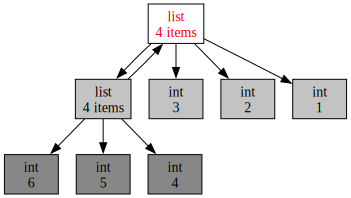

In [1]:
import objgraph

a = [1, 2, 3]
b = [4, 5, 6]

a.append(b)
b.append(a)

objgraph.show_refs([a])


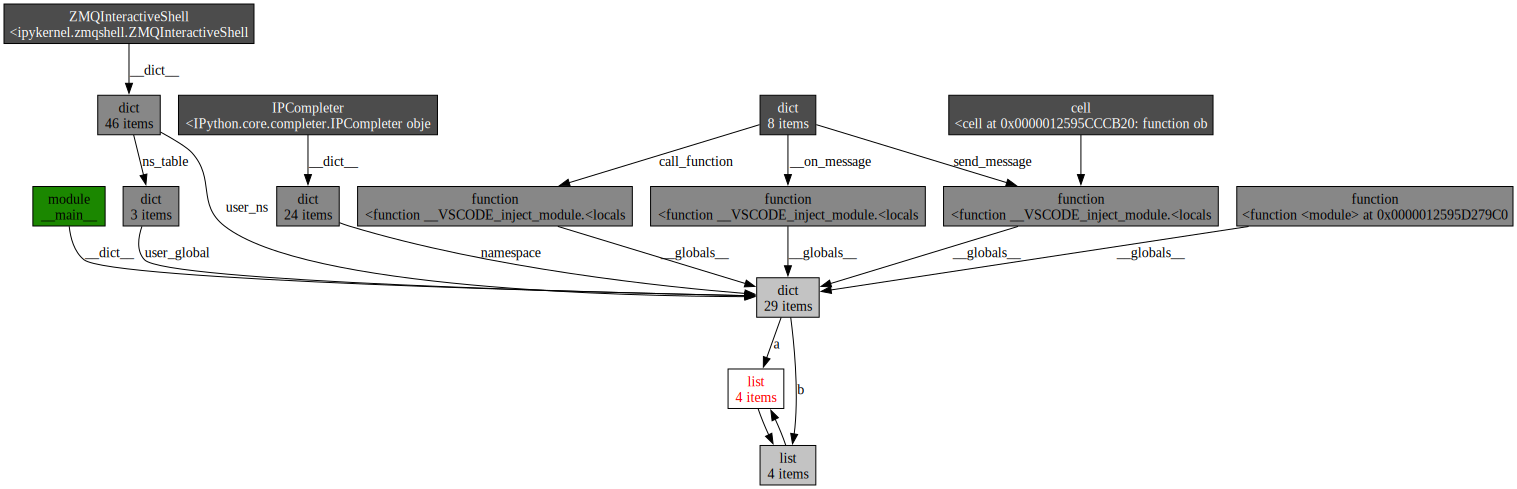

In [2]:
import objgraph

a = [1, 2, 3]
b = [4, 5, 6]

a.append(b)
b.append(a)

objgraph.show_backrefs([a])


# 总结

1. 垃圾回收是 Python 自带的机制，用于自动释放不会再用到的内存空间； 
2. 引用计数是其中最简单的实现，不过切记，这只是充分非必要条件，因为循环引用需要通过不可达判定，来确定是否可以回收； 
3. Python 的自动回收算法包括标记清除和分代收集，主要针对的是循环引用的垃圾收集； 
4. 调试内存泄漏方面， objgraph 是很好的可视化分析工具。